### Medical Appoitment No Shown Project
(Kaggle: https://www.kaggle.com/joniarroba/noshowappointments)

In this project...

### Import libraries 

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

### Load data and EDA

In [2]:
df = pd.read_csv('KaggleV2-May-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
df.shape #we have 110527 rows and 14 columns

(110527, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


We have couple things to mention after taking a closer look on the data:
* There is **no NaN value in the dataset** which is good news
* **Patient ID** is a float **not Int**, so I will convert it to Int64
* **ScheduledDay** and **AppointmentDay** are Objects **not DateTimes**, so I will convert it to DateTime
* Typeos in column names
* We have to handle that **ScheduledDay has times (hour/minute)** while **AppointmentDay only includes T00:00:00Z**

In [5]:
#patientID to Int
df["PatientId"] = df["PatientId"].astype('int64')

#convert Objects to DateTimes
df["ScheduledDay"] = pd.to_datetime(df["ScheduledDay"], format = '%Y-%m-%dT%H:%M:%SZ', errors = 'coerce')
df["AppointmentDay"] = pd.to_datetime(df["AppointmentDay"], format = '%Y-%m-%dT%H:%M:%SZ', errors = 'coerce')

#correct typeos
df = df.rename(columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'SMS_received': 'SMSReceived', 'No-show': 'NoShow'})

In [6]:
#make sure all the dates are in the right format
assert df.ScheduledDay.isnull().sum() == 0, 'missing ScheduledDay dates'
assert df.AppointmentDay.isnull().sum() == 0, 'missing AppointmentDay dates'

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   PatientId       110527 non-null  int64         
 1   AppointmentID   110527 non-null  int64         
 2   Gender          110527 non-null  object        
 3   ScheduledDay    110527 non-null  datetime64[ns]
 4   AppointmentDay  110527 non-null  datetime64[ns]
 5   Age             110527 non-null  int64         
 6   Neighbourhood   110527 non-null  object        
 7   Scholarship     110527 non-null  int64         
 8   Hypertension    110527 non-null  int64         
 9   Diabetes        110527 non-null  int64         
 10  Alcoholism      110527 non-null  int64         
 11  Handicap        110527 non-null  int64         
 12  SMSReceived     110527 non-null  int64         
 13  NoShow          110527 non-null  object        
dtypes: datetime64[ns](2), int64(9), obje

Since _PatientId_ and _AppointmentID_ are just some system generated numbers and shouldn't be used for predicting the target variable, I will remove them.

In [8]:
df.drop(["PatientId","AppointmentID"],axis=1, inplace=True)

Let's check some irregular cases, firstly the age of the patients(can't be < 0) or that the _ScheduledDay_ can't be later than the _AppointmentDay_

In [12]:
print("Patients with `Age` less than 0 -> {}".format(df[df.Age < 0].shape[0])) #we assume that this is a type so we are going to remove it
print("Patients with `Age` equal to 0 -> {}".format(df[df.Age == 0].shape[0])) #those are babies, but we will make sure

Patients with `Age` less than 0 -> 1
Patients with `Age` equal to 0 -> 3539


In [13]:
df = df[df.Age >= 0] #remove that 1 row

Most of the times babies do not have _Alcoholism_ or _Hypertension_, therefore we are going to analyze these features.

In [14]:
df[(df.Age == 0) & ((df.Hypertension.astype(int) == 1) | (df.Alcoholism.astype(int) == 1))]

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow


Since there is no any results, we can assume that our hyphothesis that those are babies are true so we are going to keep these rows.

In [17]:
(df['ScheduledDay'] > df['AppointmentDay']).sum() #there are approximately 40k appointments that were scheduled after
                                                  #the appointment day
                                                  #However, It is due to fact that all the appointment times were set at the
                                                  #earliest time (T:00:00:0Z) while times are included in ScheduledDay

38567

In [18]:
df['AppointmentDay'] = df['AppointmentDay'] + pd.Timedelta('1d')-pd.Timedelta('1s') #changing the date to (23:59:59)

In [20]:
(df['ScheduledDay'] > df['AppointmentDay']).sum() #after chaning the time only 5 rows left were the Scheduled time is after the
                                                  #appointment time, so we are going to drop these 5 rows

5

In [23]:
df = df.drop(df[df.ScheduledDay > df.AppointmentDay].index) #drop those 5 rows

In [24]:
df

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
0,F,2016-04-29 18:38:08,2016-04-29 23:59:59,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,2016-04-29 16:08:27,2016-04-29 23:59:59,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,2016-04-29 16:19:04,2016-04-29 23:59:59,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,2016-04-29 17:29:31,2016-04-29 23:59:59,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,2016-04-29 16:07:23,2016-04-29 23:59:59,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...
110522,F,2016-05-03 09:15:35,2016-06-07 23:59:59,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,F,2016-05-03 07:27:33,2016-06-07 23:59:59,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,F,2016-04-27 16:03:52,2016-06-07 23:59:59,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,F,2016-04-27 15:09:23,2016-06-07 23:59:59,38,MARIA ORTIZ,0,0,0,0,0,1,No


In [26]:
#Adding new columns which will be created by using DateTime columns
#First - Waiitng Time in Days
df['Waiting_Time_days'] = df['AppointmentDay'] - df['ScheduledDay']
df['Waiting_Time_days'] = df['Waiting_Time_days'].dt.days

#Secondly - Day of the Week (both Schedule and Appointment day)
df['ScheduledDay_DOfW'] = df['ScheduledDay'].dt.day_name()
df['AppointmentDay_DOfW'] = df['AppointmentDay'].dt.day_name()

In [95]:
df.sample(n=10)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,Waiting_Time_days,ScheduledDay_DOfW,AppointmentDay_DOfW
72865,M,2016-05-11 07:19:19,2016-05-11 23:59:59,30,ANDORINHAS,0,0,0,0,0,0,No,0,Wednesday,Wednesday
67973,F,2016-03-23 10:25:25,2016-05-11 23:59:59,50,JARDIM CAMBURI,0,0,0,0,0,1,No,49,Wednesday,Wednesday
90016,F,2016-05-20 16:25:02,2016-06-03 23:59:59,43,SÃO PEDRO,1,0,0,0,0,1,Yes,14,Friday,Friday
89885,M,2016-04-26 07:59:33,2016-06-06 23:59:59,13,BONFIM,0,0,0,0,0,1,No,41,Tuesday,Monday
90756,F,2016-06-08 10:18:19,2016-06-08 23:59:59,1,JARDIM DA PENHA,0,0,0,0,0,0,No,0,Wednesday,Wednesday
49465,F,2016-05-06 07:41:59,2016-05-12 23:59:59,37,SANTOS DUMONT,1,0,0,0,0,1,No,6,Friday,Thursday
63736,F,2016-05-03 13:02:39,2016-05-20 23:59:59,48,DA PENHA,1,0,0,0,0,0,No,17,Tuesday,Friday
107922,M,2016-04-01 11:55:57,2016-06-03 23:59:59,32,RESISTÊNCIA,0,0,0,0,0,0,Yes,63,Friday,Friday
31088,F,2016-04-19 09:10:16,2016-05-03 23:59:59,47,BENTO FERREIRA,0,0,0,0,0,1,No,14,Tuesday,Tuesday
36789,M,2016-05-04 13:11:40,2016-05-04 23:59:59,7,RESISTÊNCIA,0,0,0,0,0,0,No,0,Wednesday,Wednesday


**Check Show/NoShow ration**

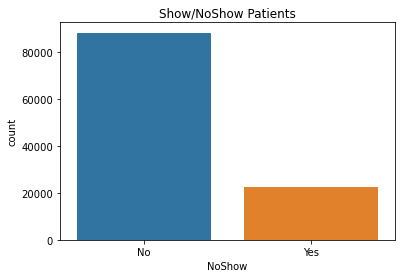

In [98]:
ax = sns.countplot(x=df.NoShow, data=df)
ax.set_title("Show/NoShow Patients")
plt.show()

**!!!IMPORTANT!!! - Clearly IMBALANCED DATASET**

**Show/NoShow ration in genders**

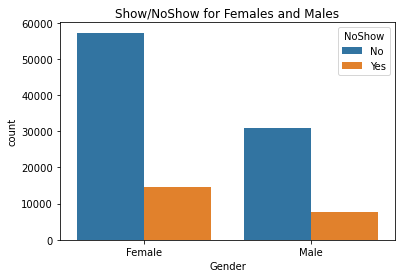

In [99]:
ax = sns.countplot(x=df.Gender, hue=df.NoShow, data=df)
ax.set_title("Show/NoShow for Females and Males")
x_ticks_labels=['Female', 'Male']
ax.set_xticklabels(x_ticks_labels)
plt.show()

**Show/NoShow by Age**

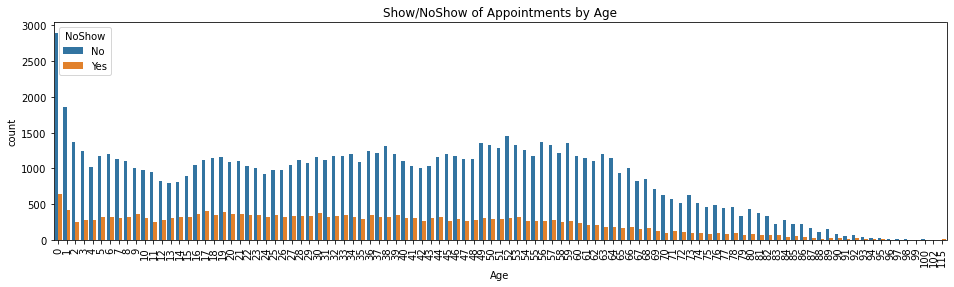

In [100]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=df.Age, hue=df.NoShow)
ax.set_title("Show/NoShow of Appointments by Age")
plt.show()

**Show/NoShow by Neighbourhood**

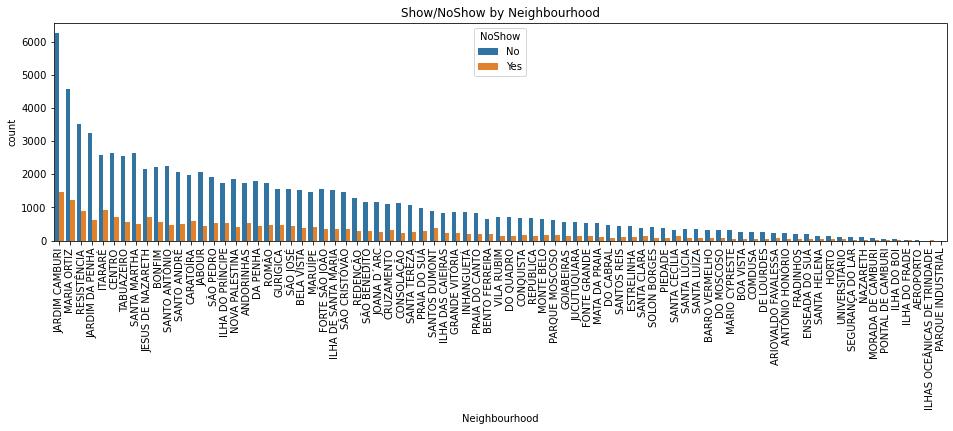

In [103]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=df.Neighbourhood, hue=df.NoShow, order=df.Neighbourhood.value_counts().index)
ax.set_title("Show/NoShow by Neighbourhood")
plt.show()

**Show/NoShow by DOfW** 

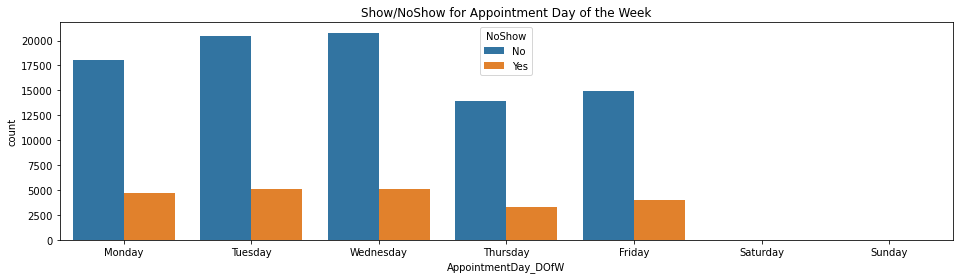

In [106]:
week_key = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.figure(figsize=(16,4))
ax = sns.countplot(x=df.AppointmentDay_DOfW, hue=df.NoShow, order=week_key)
ax.set_title("Show/NoShow for Appointment Day of the Week")
plt.show()

**Waiting time and Show/NoShow ratio**

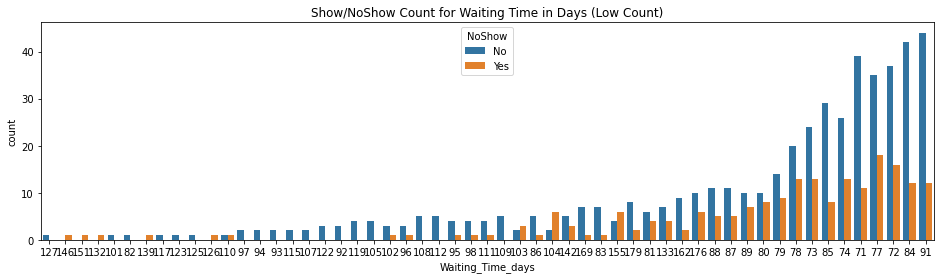

In [107]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x=df.Waiting_Time_days, hue=df.NoShow, order=df.Waiting_Time_days.value_counts(ascending=True).iloc[:55].index)
ax.set_title("Show/NoShow Count for Waiting Time in Days (Low Count)")
plt.show()

Adding extra columns by extracting information from DateTime and after drop it.

In [108]:
df['ScheduledDay_Y'] = df['ScheduledDay'].dt.year
df['ScheduledDay_M'] = df['ScheduledDay'].dt.month
df['ScheduledDay_D'] = df['ScheduledDay'].dt.day
df.drop(['ScheduledDay'], axis=1, inplace=True)

df['AppointmentDay_Y'] = df['AppointmentDay'].dt.year
df['AppointmentDay_M'] = df['AppointmentDay'].dt.month
df['AppointmentDay_D'] = df['AppointmentDay'].dt.day
df.drop(['AppointmentDay'], axis=1, inplace=True)

In [110]:
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,Waiting_Time_days,ScheduledDay_DOfW,AppointmentDay_DOfW,ScheduledDay_Y,ScheduledDay_M,ScheduledDay_D,AppointmentDay_Y,AppointmentDay_M,AppointmentDay_D
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0,Friday,Friday,2016,4,29,2016,4,29
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0,Friday,Friday,2016,4,29,2016,4,29
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,0,Friday,Friday,2016,4,29,2016,4,29
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0,Friday,Friday,2016,4,29,2016,4,29
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0,Friday,Friday,2016,4,29,2016,4,29
